<h1>FIFA 23 ML Project  <img src="https://img.icons8.com/color/48/null/football-team.png"/></h1>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("./players_fifa23_cleaned.csv")
data.head()

,ID,Name,FullName,Age,Height,Weight,PhotoUrl,Nationality,Overall,Potential,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
0,158023,L. Messi,Lionel Messi,35,169,67,https://cdn.sofifa.net/players/158/023/23_60.png,Argentina,91,91,...,91,88,91,67,66,67,62,53,62,22
1,165153,K. Benzema,Karim Benzema,34,185,81,https://cdn.sofifa.net/players/165/153/23_60.png,France,91,91,...,89,84,89,67,67,67,63,58,63,21
2,188545,R. Lewandowski,Robert Lewandowski,33,185,81,https://cdn.sofifa.net/players/188/545/23_60.png,Poland,91,91,...,86,83,86,67,69,67,64,63,64,22
3,192985,K. De Bruyne,Kevin De Bruyne,31,181,70,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,91,91,...,91,91,91,82,82,82,78,72,78,24
4,231747,K. Mbappé,Kylian Mbappé,23,182,73,https://cdn.sofifa.net/players/231/747/23_60.png,France,91,95,...,92,84,92,70,66,70,66,57,66,21


In [4]:
data.shape

(18539, 90)

In [5]:
needed_columns = ['ID', 'Name', 'Age', 'Height', 'Weight',
       'Overall', 'Potential', 'Growth', 'TotalStats',
       'BaseStats', 'BestPosition', 'Club', 'ValueEUR', 'WageEUR',
       'ReleaseClause', 'ContractUntil', 'ClubJoined', 'OnLoad',
       'PreferredFoot', 'IntReputation', 'WeakFoot','Nationality',
       'SkillMoves', 'AttackingWorkRate', 'DefensiveWorkRate', 'PaceTotal',
       'ShootingTotal', 'PassingTotal', 'DribblingTotal', 'DefendingTotal',
       'PhysicalityTotal', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


data = data[needed_columns]

<img src="https://gamesmix.net/wp-content/uploads/2022/03/FIFA-23.jpeg" width="900"/>

# Modeling

## B. Group the Players in Clusters Based on their Similarities Using 4 Clustering Algorithms:

<h3>Extracting players with overall above 86:</h3>

In [137]:
X_clus = data[data.Overall > 86] 
X_clus.shape

(43, 65)

In [138]:
names = X_clus["Name"].tolist() # saving names for later

X_clus = X_clus.drop(['Name', 'Nationality', 'ID'], axis = 1)

#Feature Scaling
X_clus = mms.fit_transform(X_clus)

<h3>Perform Dimentionality Reduction:</h3>

In [139]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) # Reduce the Dimention of the Data to its half
X_clus = pd.DataFrame(pca.fit_transform(X_clus))

<h2>Clustering:</h2>

In [140]:
clus_names = []
clus_scores = []

<h3>1. KMeans:</h3>

<h4>Use the Elbow function to determine the optimal number of Clusters:</h4>

In [141]:
import random
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

visualizer = KElbowVisualizer(KMeans(), timings=False)

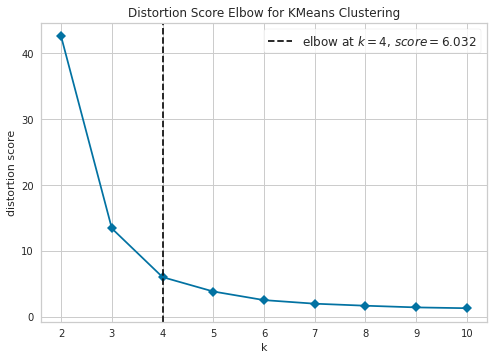

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [142]:
visualizer.fit(X_clus)
visualizer.show()

<h4>So the Optimal number of clusters is 4</h4>

In [143]:
kmeans = KMeans(n_clusters=4)

kmeans = kmeans.fit(X_clus)

# get the cluster labels
labels = kmeans.predict(X_clus)

# cluster values
kmeans_clusters = kmeans.labels_.tolist()

In [144]:
X_kmeans = X_clus.copy()
X_kmeans['cluster'] = kmeans_clusters
X_kmeans['name'] = names
X_kmeans.columns = ['x', 'y', 'cluster', 'name']
X_kmeans.head()

,x,y,cluster,name
0,-1.271683,-1.648421,0,L. Messi
1,-0.975886,-1.192317,0,K. Benzema
2,-1.189627,-1.173911,0,R. Lewandowski
3,-1.600086,-0.517118,3,K. De Bruyne
4,-1.335628,-1.381503,0,K. Mbappé


<h3>Plot the Clusters of the K-means Algorithm:</h3>

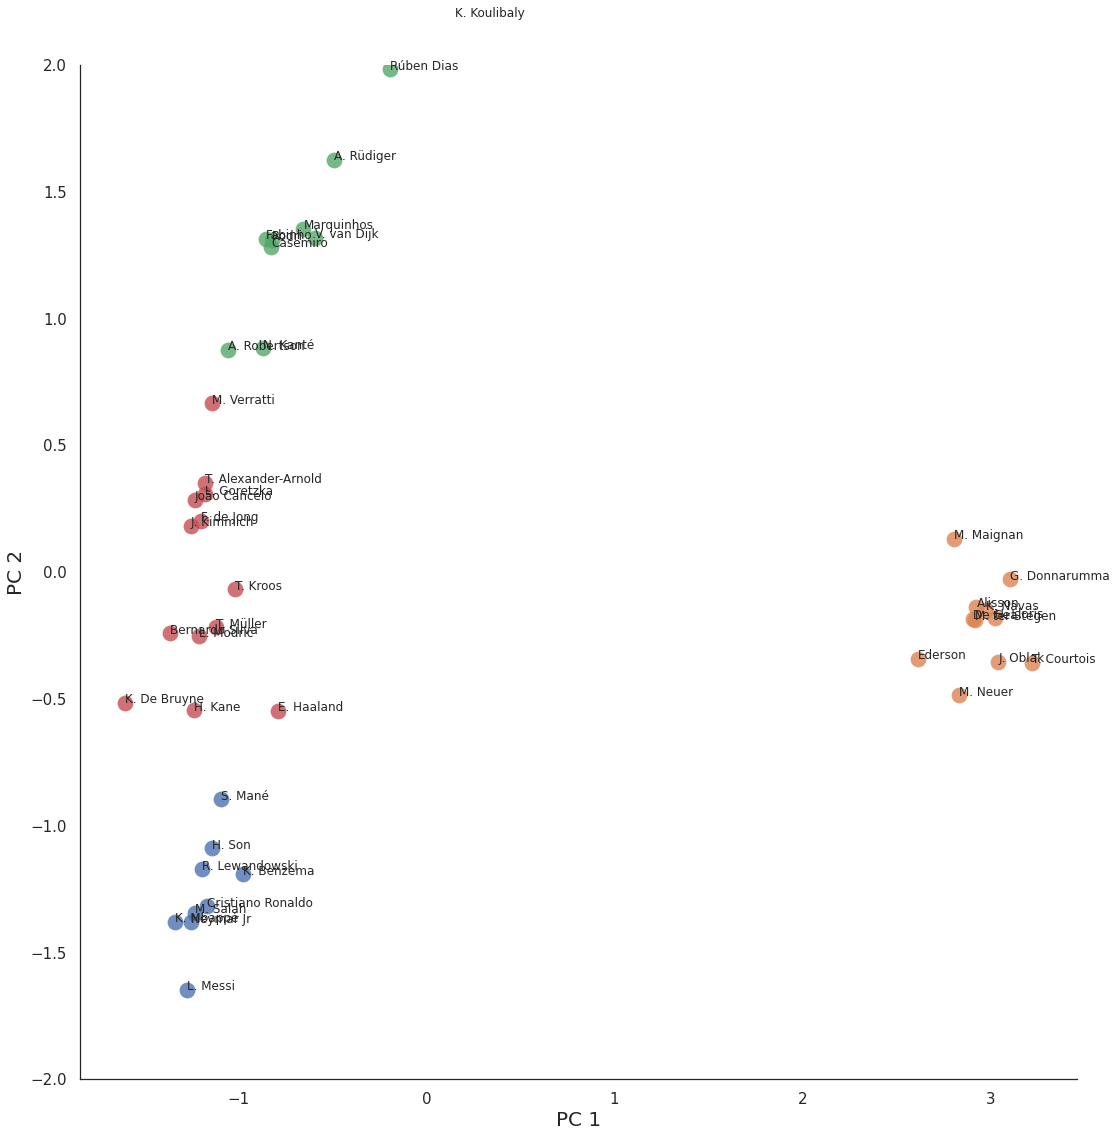

In [145]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = X_kmeans, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(X_kmeans.x, X_kmeans.y, X_kmeans.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

<h3>Evaluate the K-means algorithm using Silhouette coefficient:</h3>

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample. The score is bounded between <b>-1 for incorrect clustering and +1 for highly dense clustering</b>. </br>
Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated.

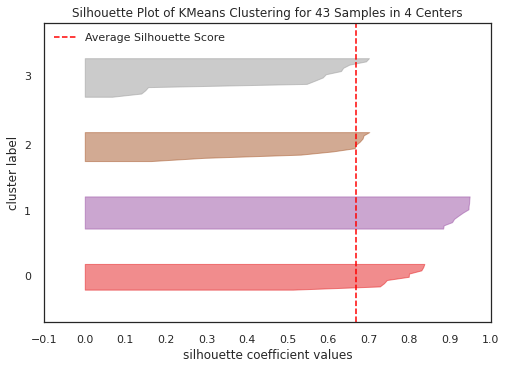

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 43 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [146]:
sil_visualizer = SilhouetteVisualizer(kmeans)
sil_visualizer.fit(X_clus)    
sil_visualizer.show()

In [147]:
silhouette_score(X_clus, kmeans.labels_)

0.6694690209060634

In [148]:
clus_names.append("K-means")
clus_scores.append(silhouette_score(X_clus, kmeans.labels_))

<h3>2. Hirerichal Clustering:</h3>

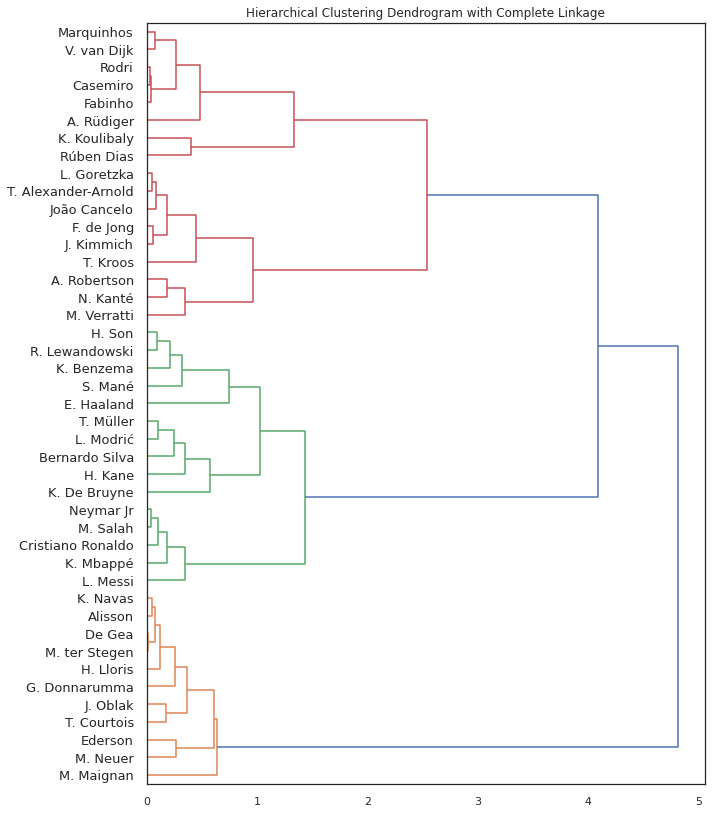

In [149]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# plot dendrogram using complete linkage
plt.figure(figsize=(10,14))
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')

dendrogram = sch.dendrogram(sch.linkage(X_clus, method="complete"), labels= names, leaf_font_size = 13, orientation='right')

In [150]:
unique_colors = set(dendrogram['color_list'])
num_clusters_hir = len(unique_colors)
print("Optimal number of clusters is : ", num_clusters_hir)

Optimal number of clusters is :  4


In [151]:
from sklearn.cluster import AgglomerativeClustering
cluster_hir = AgglomerativeClustering(n_clusters=num_clusters_hir, affinity='euclidean', linkage='ward')
cluster_hir.fit_predict(X_clus)

# cluster values
hir_clusters = cluster_hir.labels_.tolist()

In [152]:
print("Estimated number of noise points:", list(cluster_hir.labels_).count(-1))

Estimated number of noise points: 0


In [153]:
X_hir = X_clus.copy()
X_hir['cluster'] = hir_clusters
X_hir['name'] = names
X_hir.columns = ['x', 'y', 'cluster', 'name']
X_hir.head()

,x,y,cluster,name
0,-1.271683,-1.648421,1,L. Messi
1,-0.975886,-1.192317,1,K. Benzema
2,-1.189627,-1.173911,1,R. Lewandowski
3,-1.600086,-0.517118,0,K. De Bruyne
4,-1.335628,-1.381503,1,K. Mbappé


<h3>Plot the Clusters of the Hirerichal Clustering Algorithm:</h3>

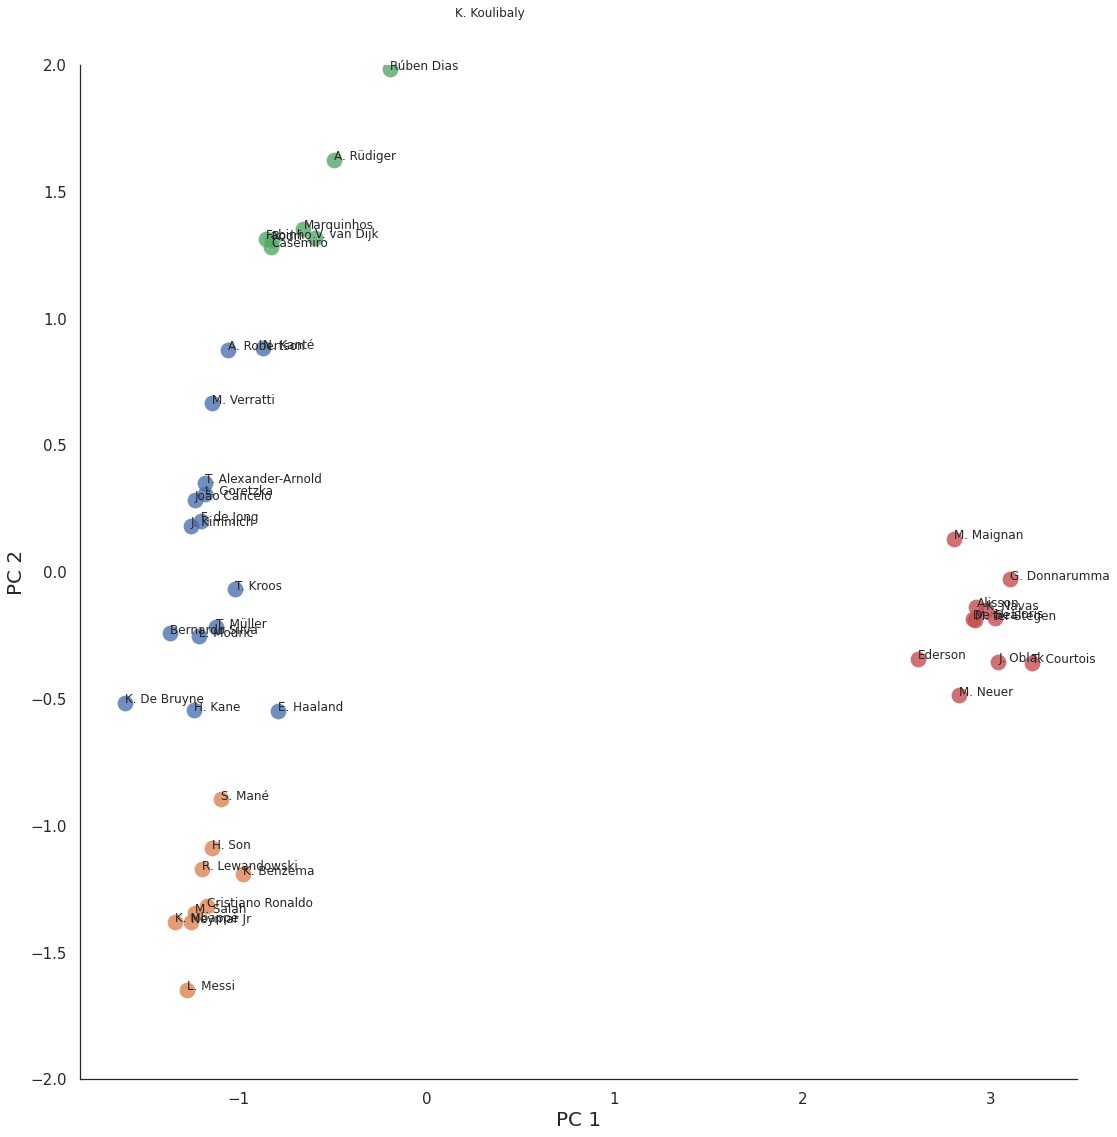

In [154]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = X_hir, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(X_hir.x, X_hir.y, X_hir.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

<h3>Evaluate the Hirerichal Clustring algorithm using Silhouette coefficient:</h3>

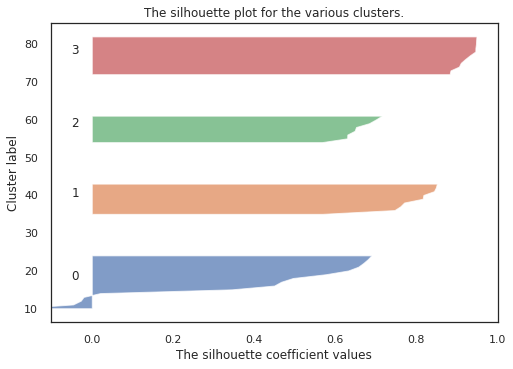

In [155]:
cluster_labels = cluster_hir.labels_
silhouette_avg = silhouette_score(X_clus, cluster_hir.labels_)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_clus, cluster_labels)

fig, ax1 = plt.subplots(1)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-0.1, 1])


y_lower = 10
for i in range(num_clusters_hir):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                     alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


plt.show()

In [156]:
silhouette_score(X_clus, cluster_hir.labels_)

0.6467505864041747

In [157]:
clus_names.append("Hirerichal Clustering")
clus_scores.append(silhouette_score(X_clus, cluster_hir.labels_))

<h3>3. Density-based clustering (DBSCAN):</h3>

In [158]:
from sklearn.cluster import DBSCAN

# train the model using DBSCAN
db = DBSCAN(eps=0.429, min_samples=5)
db.fit_predict(X_clus)

# prediction for dbscan clusters
db_clusters = db.labels_.tolist()

In [159]:
print("Number of Cluster in the Density Based Clustering:", len(set(db_clusters)))

Number of Cluster in the Density Based Clustering: 4


In [160]:
X_db = X_clus.copy()
X_db['cluster'] = db_clusters
X_db['name'] = names
X_db.columns = ['x', 'y', 'cluster', 'name']
X_db.head()

,x,y,cluster,name
0,-1.271683,-1.648421,0,L. Messi
1,-0.975886,-1.192317,0,K. Benzema
2,-1.189627,-1.173911,0,R. Lewandowski
3,-1.600086,-0.517118,0,K. De Bruyne
4,-1.335628,-1.381503,0,K. Mbappé


<h3>Plot the Clusters of the DBSCAN Clustering Algorithm:</h3>

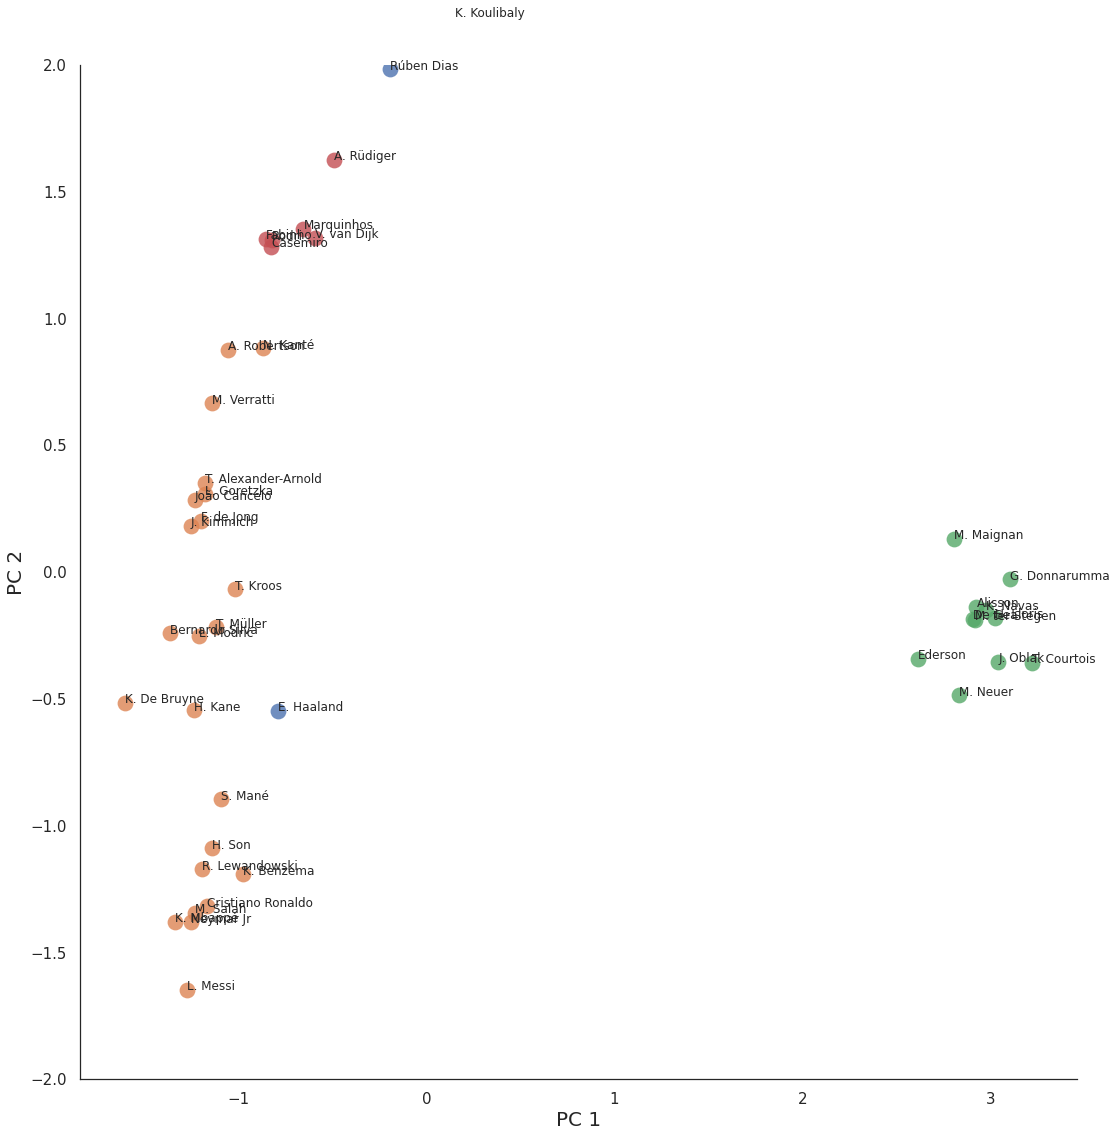

In [161]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = X_db, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(X_db.x, X_db.y, X_db.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

<h3>Evaluate the DBSCAN Clustring algorithm using Silhouette coefficient:</h3>

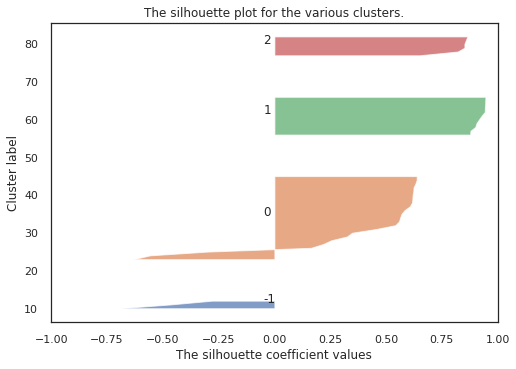

In [162]:
cluster_labels = db.labels_
silhouette_avg = silhouette_score(X_clus, db.labels_)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_clus, cluster_labels)
fig, ax1 = plt.subplots(1)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-1, 1])

num_clusters = len(set(db_clusters))
y_lower = 10
for i in range(-1, num_clusters-1):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                     alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

plt.show()

In [163]:
silhouette_score(X_clus, db.labels_)

0.5185138125548274

In [164]:
clus_names.append("DBSCAN")
clus_scores.append(silhouette_score(X_clus, db.labels_))

<h3>4. Distribution-based clustering:</h3>

In [165]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
gmm.fit(X_clus)

gmm_clusters = gmm.predict(X_clus).tolist()

In [166]:
X_gmm = X_clus.copy()
X_gmm['cluster'] = gmm_clusters
X_gmm['name'] = names
X_gmm.columns = ['x', 'y', 'cluster', 'name']
X_gmm.head()

,x,y,cluster,name
0,-1.271683,-1.648421,0,L. Messi
1,-0.975886,-1.192317,0,K. Benzema
2,-1.189627,-1.173911,0,R. Lewandowski
3,-1.600086,-0.517118,3,K. De Bruyne
4,-1.335628,-1.381503,0,K. Mbappé


<h3>Plot the Clusters of the Distribution-based Clustering Algorithm:</h3>

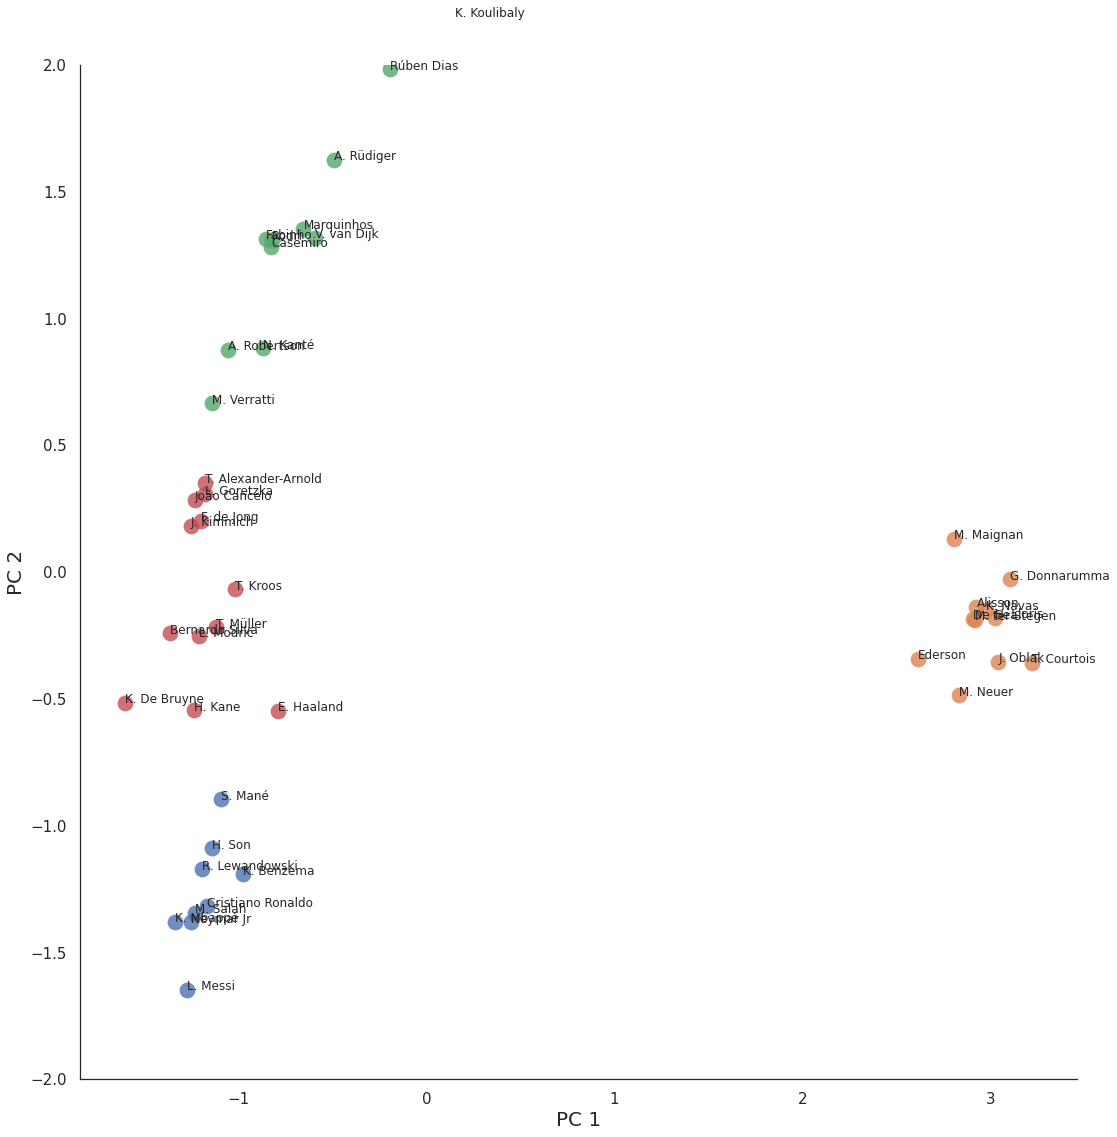

In [167]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = X_gmm, legend=False,
                   fit_reg=False, height = 15, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(X_gmm.x, X_gmm.y, X_gmm.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

<h3>Evaluate the Distribution-based Clustring algorithm using Silhouette coefficient:</h3>

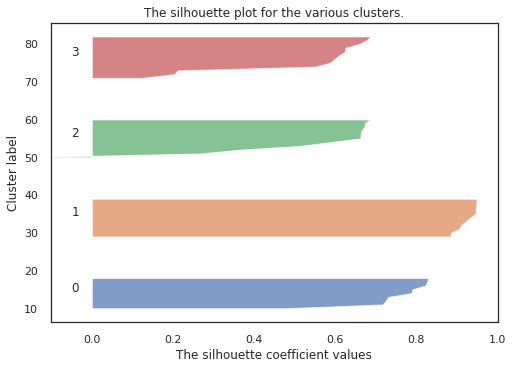

In [168]:
cluster_labels = np.array(gmm_clusters)
silhouette_avg = silhouette_score(X_clus, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_clus, cluster_labels)
fig, ax1 = plt.subplots(1)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-0.1, 1])

num_clusters = len(set(gmm_clusters))
y_lower = 10
for i in range(num_clusters):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                     alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

plt.show()

In [169]:
silhouette_score(X_clus, cluster_labels)

0.6658412915904283

In [170]:
clus_names.append("Distribution-based")
clus_scores.append(silhouette_score(X_clus, cluster_labels))

<h3>Compare the 4 Clustring Algorithms based on the Silhouette Score:</h3>

In [171]:
comp = pd.DataFrame()
comp['name'] = clus_names
comp['score'] = clus_scores
comp

,name,score
0,K-means,0.669469
1,Hirerichal Clustering,0.646751
2,DBSCAN,0.518514
3,Distribution-based,0.665841


In [172]:
cm = sns.light_palette("green", as_cmap=True)
s = comp.style.background_gradient(cmap=cm)
s

,name,score
0,K-means,0.669469
1,Hirerichal Clustering,0.646751
2,DBSCAN,0.518514
3,Distribution-based,0.665841


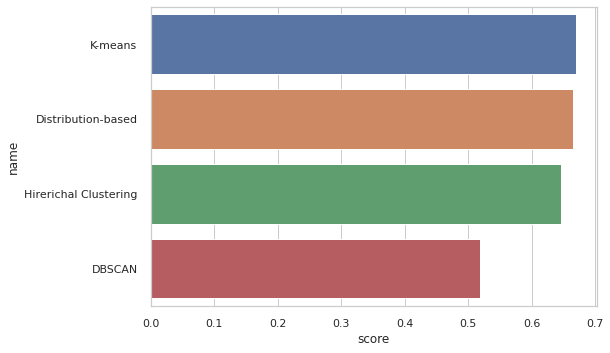

In [173]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=comp.sort_values(by="score", ascending=False))

<h3>So Based on The Silhouette Score, The Hirerichal Clustring and the K-means are the best Clustering Algorithms for this Data.</h3>